In [5]:
pip install catboost

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [7]:
# Load the dataset
data = pd.read_csv('/content/tesla.csv')
data = data.dropna()

In [8]:
# EDA
# Check for missing values
print(data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [9]:
# Summary statistics
print(data.describe())

              Open         High          Low        Close    Adj Close  \
count  2193.000000  2193.000000  2193.000000  2193.000000  2193.000000   
mean    175.652882   178.710262   172.412075   175.648555   175.648555   
std     115.580903   117.370092   113.654794   115.580771   115.580771   
min      16.139999    16.629999    14.980000    15.800000    15.800000   
25%      33.110001    33.910000    32.459999    33.160000    33.160000   
50%     204.990005   208.160004   201.669998   204.990005   204.990005   
75%     262.000000   265.329987   256.209991   261.739990   261.739990   
max     386.690002   389.609985   379.350006   385.000000   385.000000   

             Volume  
count  2.193000e+03  
mean   5.077449e+06  
std    4.545398e+06  
min    1.185000e+05  
25%    1.577800e+06  
50%    4.171700e+06  
75%    6.885600e+06  
max    3.716390e+07  


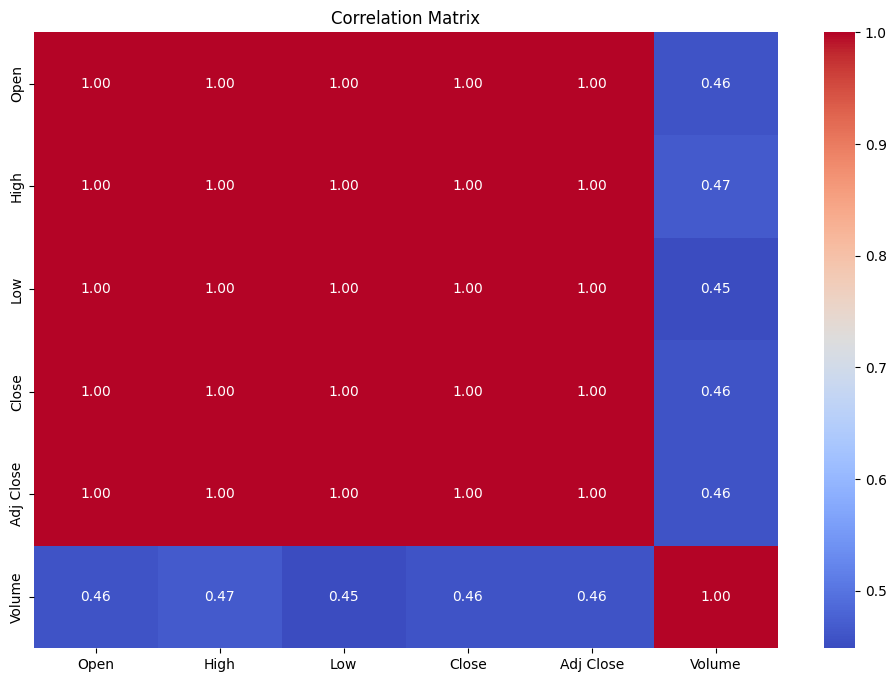

In [10]:
# Correlation matrix (excluding the 'Date' column)
plt.figure(figsize=(12, 8))
sns.heatmap(data.drop(columns=['Date']).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

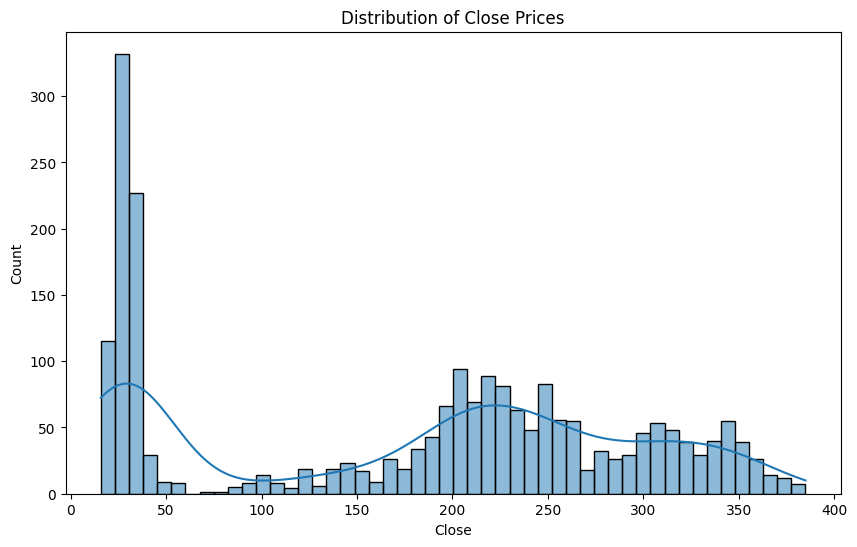

In [11]:
# Distribution of 'Close' price
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], bins=50, kde=True)
plt.title('Distribution of Close Prices')
plt.show()

In [12]:
# Create features and labels
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

<ipython-input-12-6078241aa6e9>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])


In [13]:
# Create lagged features
for lag in range(1, 11):
    data[f'Close_lag_{lag}'] = data['Close'].shift(lag)

In [14]:
# Add more technical indicators as features
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['RSI'] = data['Close'].diff().rolling(window=14).apply(lambda x: np.mean(np.where(x > 0, x, 0)) / (np.mean(np.abs(x)) + 1e-10), raw=True)
data['EMA10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()

In [15]:
data.dropna(inplace=True)

In [16]:
# Prepare feature and target arrays
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'MA10', 'MA50', 'RSI', 'EMA10', 'EMA50'] + [f'Close_lag_{lag}' for lag in range(1, 11)]
X = data[features]
y = data['Close']

In [17]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [19]:
# Initialize the CatBoost Regressor
cbr = CatBoostRegressor(verbose=0)

In [20]:
# Define the parameter grid
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5]
}

In [21]:
# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(cbr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7dff13853b80>,
             param_grid={'depth': [3, 5, 7], 'iterations': [500, 1000],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.1, 0.2]},
             scoring='neg_mean_squared_error')

In [22]:
# Get the best estimator
best_cbr = grid_search.best_estimator_

In [23]:
# Make predictions on the testing set
y_pred = best_cbr.predict(X_test)

In [24]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [25]:
# Calculate a custom accuracy metric
def custom_accuracy(y_true, y_pred, tolerance=0.05):
    return np.mean(np.abs((y_true - y_pred) / y_true) <= tolerance)

accuracy = custom_accuracy(y_test, y_pred)

In [26]:
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')
print(f'Custom Accuracy: {accuracy * 100:.2f}%')

Mean Absolute Error (MAE): 1.2153340067043956
Mean Squared Error (MSE): 3.517023660581572
R-squared (R2): 0.9997353525126849
Custom Accuracy: 98.60%


In [27]:
# Make a prediction on new data
new_data = pd.DataFrame({
    'Open': [300],
    'High': [310],
    'Low': [295],
    'Adj Close': [305],
    'Volume': [1000000],
    'MA10': [305],
    'MA50': [310],
    'RSI': [0.01],
    'EMA10': [305],
    'EMA50': [310],
    'Close_lag_1': [298],
    'Close_lag_2': [299],
    'Close_lag_3': [297],
    'Close_lag_4': [296],
    'Close_lag_5': [295],
    'Close_lag_6': [294],
    'Close_lag_7': [293],
    'Close_lag_8': [292],
    'Close_lag_9': [291],
    'Close_lag_10': [290]
})

In [28]:
new_data_scaled = scaler.transform(new_data)
new_prediction = best_cbr.predict(new_data_scaled)
print(f'Predicted Close Price: {new_prediction[0]}')

Predicted Close Price: 306.3758847025875
